# Multilayer Perceptron for MNIST Classification

In this notebook we will use a Multilayer Perceptron (or MLP, for short) to make predictions on the famous MNIST dataset.

## Getting the Data

MNIST is so pervasive in the world of both deep learning and computer vision, that many frameworks, such as Keras, come bundled with it. Hence, we just need to call a function to make Keras download it and give us both the train and tests sets.

In [1]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f'Number of training examples: {len(X_train)}')
print(f'Number of test examples: {len(X_test)}')

Using TensorFlow backend.


Number of training examples: 60000
Number of test examples: 10000


So, in total, MNIST is composed of 70.000 images, where 60.000 are for training and 10.000 for testing. 

## Visualizing Images from MNIST

An excellent way to gain an understanding of the data we are dealing with is taking a look at a couple of examples. Let's do it:

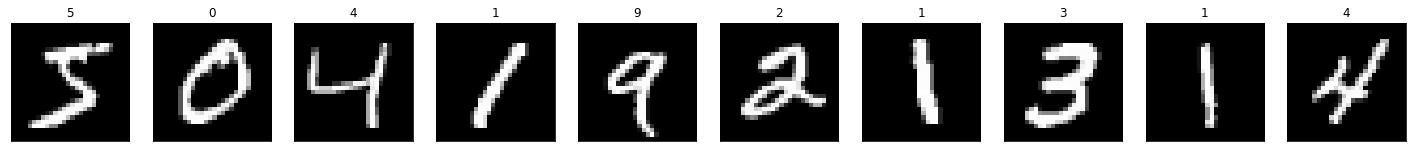

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

SAMPLE_SIZE = 10

# Plot the images in the sample
figure = plt.figure(figsize=(25, 25))

for sample_index in range(SAMPLE_SIZE):
    ax = figure.add_subplot(1, SAMPLE_SIZE, sample_index + 1, xticks=[], yticks=[])
    ax.imshow(X_train[sample_index], cmap='gray')
    ax.set_title(y_train[sample_index])


In the graph above we see a couple of instances of the data. Among the examples in the sample, there a few that correspond to the same sumber, such as 4 and 1. We can observe they have subtle differences. The job of our network, then, will be to capture all these nuances in order to predict the number that's depicted in each image.

## Full Detailed Image

Just for understanding better what the computer is actually seeing, let's see one of these images in its true form: As a matrix.

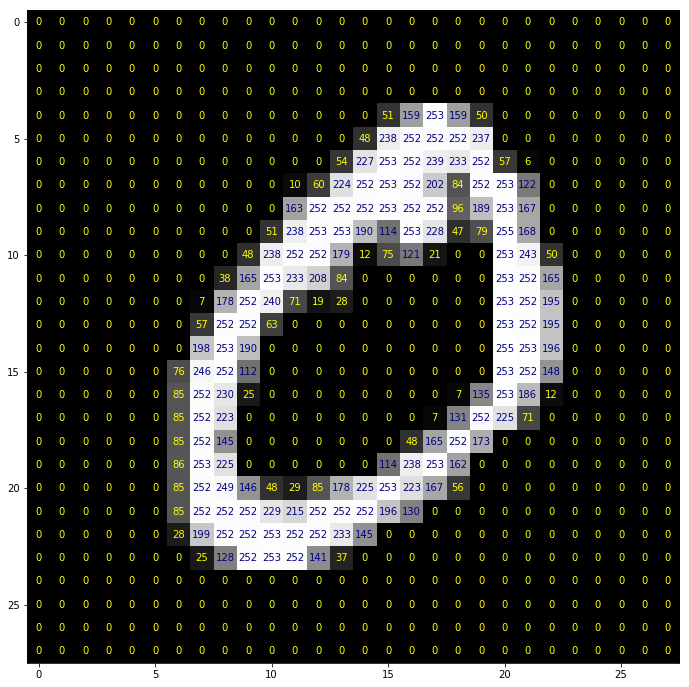

In [3]:
def visualize_input(image, ax):
    ax.imshow(image, cmap='gray')
    width, height = image.shape
    threshold = image.max() / 2.5
    
    for x in range(width):
        for y in range(height):
            pixel_value = image[x][y]
            ax.annotate(f'{round(pixel_value, 2)}', 
                        xy=(y, x),
                       horizontalalignment='center',
                       verticalalignment='center',
                       color='yellow' if pixel_value < threshold else 'navy')
            
SAMPLE_INDEX = 1            
figure = plt.figure(figsize=(12, 12))
ax = figure.add_subplot(111)
visualize_input(X_train[SAMPLE_INDEX], ax)

The underlying numbers are what the computer actually sees. Then, the job of the MLP is to make sense of this grid of numbers and somehow figure out it represents a handwritten 0.

## Rescaling the Images

A common way to rescale the images is to dividing each pixel inside them by 255, the maximum value they can take in an RGB space. This will result in each pixel containing a value between 0 and 1, instead of 0 and 255.

In [4]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

## One-hot Encoding the Labels

In order to break any possible ordering bias among the labels (i.e., 0 is better than 1, 1 better than 2, etc), we can one-hot encode them. This mean that each label will be converted to a vector of only zeroes, except in the position that represents the number of the label.

0 is represented by [1, 0, 0, 0, 0, 0, 0, 0, 0, 0].

1 is represented by [0, 1, 0, 0, 0, 0, 0, 0, 0, 0].

2 is represented by [0, 0, 2, 0, 0, 0, 0, 0, 0, 0].

.

.

.

9 is represented by [0, 0, 0, 0, 0, 0, 0, 0, 0, 1].

In [5]:
from keras.utils import np_utils

print('Sample of original labels:')
print(y_train[:10])

NUMBER_OF_LABELS = 10
y_train = np_utils.to_categorical(y_train, NUMBER_OF_LABELS)
y_test = np_utils.to_categorical(y_test, NUMBER_OF_LABELS)

print('Sample of one-hot encoded labels:')
print(y_train[:10])

Sample of original labels:
[5 0 4 1 9 2 1 3 1 4]
Sample of one-hot encoded labels:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## Model Architecture

This is the main dish of our little project. Let's define a simple 3-layered network using Kera's Sequential API.

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

# Model definition
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(NUMBER_OF_LABELS, activation='softmax'))

# Model summarization
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


669.706 parameters for such a small network! We are talking about 28x28 images! This is such a small resolution that is not very frequently encountered in real world applications. 

This can give us an idea of one of the biggest issues with MLPs: scalability.

## Compile the Model

Now that the model is defined, we can compile it. To optimize it, we'll use Adam, which is a good default optimizer.

The metric will use to measure our progress is accuracy.

In [7]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Accuracy Without Training

Just as a curiosity, let's see how well our model does without even looking at the training data. We should expect an accuracy score around 10%, which is similar to what we'd get by random guessing.

In [8]:
score = model.evaluate(X_test, y_test)

print(f'Test accuracy: {100 * score[1]}%')

10000/10000 [==============================] - 1s 64us/step
Test accuracy: 14.299999999999999%


## Train the Model

Let's train our MLP. We'll save only the model that achieves the best accuracy.

In [9]:
from keras.callbacks import ModelCheckpoint
import os

if not os.path.exists('saved_models'):
    os.mkdir('saved_models')
    
OUTPUT_PATH = 'saved_models/mlp.mnist.best.hdf5'
checkpointer = ModelCheckpoint(filepath=OUTPUT_PATH, save_best_only=True)

BATCH_SIZE = 256
EPOCHS = 10
model_history = model.fit(X_train, 
                          y_train, 
                          batch_size=BATCH_SIZE,
                          validation_split=0.2,
                          epochs=EPOCHS,
                          callbacks=[checkpointer],
                          shuffle=True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 4s 83us/step - loss: 0.3341 - acc: 0.9007 - val_loss: 0.1355 - val_acc: 0.9589
Epoch 2/10
48000/48000 [==============================] - 4s 88us/step - loss: 0.1259 - acc: 0.9617 - val_loss: 0.1012 - val_acc: 0.9695
Epoch 3/10
48000/48000 [==============================] - 4s 92us/step - loss: 0.0848 - acc: 0.9740 - val_loss: 0.0885 - val_acc: 0.9740
Epoch 4/10
48000/48000 [==============================] - 4s 81us/step - loss: 0.0643 - acc: 0.9805 - val_loss: 0.0776 - val_acc: 0.9758
Epoch 5/10
48000/48000 [==============================] - 4s 81us/step - loss: 0.0499 - acc: 0.9842 - val_loss: 0.0724 - val_acc: 0.9783
Epoch 6/10
48000/48000 [==============================] - 4s 83us/step - loss: 0.0397 - acc: 0.9873 - val_loss: 0.0777 - val_acc: 0.9777
Epoch 7/10
48000/48000 [==============================] - 4s 78us/step - loss: 0.0331 - acc: 0.9892 - val_loss: 0.0741 - val_acc

## Plot Model Loss and Accuracy History

Plotting the progress of both the loss and accuracy is a good practice to detect possible instances of underfitting or overfitting.

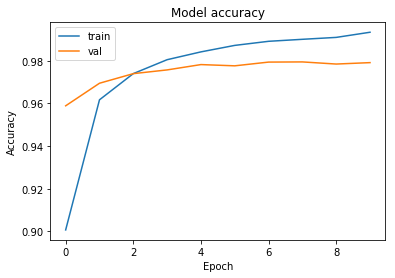

In [10]:
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

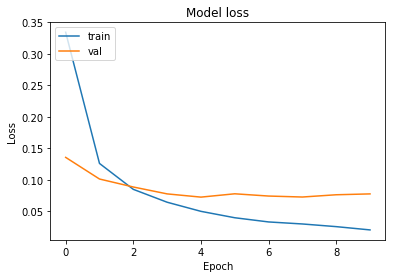

In [11]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Load Best Model

Let's load the model with the best validation accuracy and see how it performs on unseen data.

In [12]:
model.load_weights(OUTPUT_PATH)

In [13]:
score = model.evaluate(X_test, y_test)

print(f'Test accuracy: {100 * score[1]}')

10000/10000 [==============================] - 1s 53us/step
Test accuracy: 97.67
